In [45]:
# Import the necessary dependencies
import numpy as np
import matplotlib.pyplot as plt

# Initialize physical constants
k_B = 1.38e-23  #  [J/K]

# Create the Grid's class
class Grid:
    def __init__(self, Lx, Ly, nx, ny, Ex, Bz, potential_upper, potential_lower):
        """
        Initialize a 2D Grid with periodic x-boundary, constant B and potential

        Args:
            x_size (float): Physical size of the grid in the x-direction.
            y_size (float): Physical size of the grid in the y-direction.
            dx (float) : grid spacing in the x-direction
            dy (float) : grid spacing in the y-direction
            Ex (float) : Constant electric field
            Bz (float) : Constant magnetic field (out of the plane)
            potential (float) : Fixed potential
        """
        self.Lx = Lx
        self.Ly = Ly
        
        self.nx = nx
        self.ny = ny

        self.dx = Lx / nx
        self.dy = Ly / ny
        
        # Initialize the fields
        self.E = np.zeros((self.nx, self.ny, 2)) # Ex and Ey
        self.B = np.zeros((self.nx, self.ny, 1)) # Bz
        self.B[:, :, 0] = Bz # Set a constant Bz
        self.E[:, :, 0] = Ex # Set a constant Ex

        # Initialize the potential
        # self.phi = np.zeros((self.nx+1, self.ny+1, 1))
        # self.phi[:, -1] = potential_upper # Set the first upper row to a constant potential
        # self.phi[:, 0] = potential_lower # Set the first lower row to a constant potential

    def poisson_solver(self, epsilon_0, tol=1e-5, max_iter=10000):
        """
        Solve the Poisson equation using Successive Over-Relaxation (SOR).
        
        Args:
            epsilon_0 (float): Permittivity of free space.
            tol (float): Convergence tolerance.
            max_iter (int): Maximum number of iterations.
        """
        omega = 1.83  # Over-relaxation factor (1 < omega < 2)
        dx2 = self.dx**2
        dy2 = self.dy**2
        denom = 2 * (dx2 + dy2)
        
        for _ in range(max_iter):
            old_phi = self.phi.copy()
            
            # Update potential using SOR
            for i in range(1, self.nx):
                for j in range(1, self.ny):
                    self.phi[i, j] = (1 - omega) * self.phi[i, j] + omega * ((self.phi[i+1, j] + self.phi[i-1, j]) * dy2 +
                                                                             (self.phi[i, j+1] + self.phi[i, j-1]) * dx2) / denom
                    """ This is for the case where the particles interact with the electric field
                    self.phi[i, j] = (1 - omega) * self.phi[i, j] + omega * ((self.phi[i+1, j] + self.phi[i-1, j]) * dy2 +
                                                                             (self.phi[i, j+1] + self.phi[i, j-1]) * dx2 -
                                                                             self.rho[i, j] * dx2 * dy2 / epsilon_0) / denom
                                                                             """
            
            # Enforce periodic boundary in x
            self.phi[0, :] = self.phi[-2, :]
            self.phi[-1, :] = self.phi[1, :]
            
            # Check for convergence
            if np.max(np.abs(self.phi - old_phi)) < tol:
                break

    def calculate_E(self):
        """
        Calculate the electric field from the potential using finite differences
        """
        # Ex = -d(phi)/dx, Ey = -d(phi)/dy
        Ex = -(np.roll(self.phi, -1, axis=0) - np.roll(self.phi, 1, axis=0)) / (2 * self.dx)
        Ey = -(np.roll(self.phi, -1, axis=1) - np.roll(self.phi, 1, axis=1)) / (2 * self.dy)
        
        self.E[:, :, 0] = Ex  # Assign Ex to the grid
        self.E[:, :, 1] = Ey  # Assign Ey to the grid


# Create the particles class
class Particle:
    def __init__(self, x, y, vx, vy, q, m):
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
        self.q = q
        self.m = m

In [30]:
epsilon_0 = 8.854e-12  # Permittivity of free space

# Boris push function
def interpolate_field(field, x, y, dx, dy):
    """
    Perform bilinear interpolation to calculate the field value at a particle's position.

    Args:
        field (np.ndarray): 2D field array.
        x, y (float): Particle position.
        dx, dy (float): Grid spacing.

    Returns:
        float: Interpolated field value.
    """
    # Convert positions to grid indices
    i = max(0, min(int(x / dx), field.shape[0] - 1))
    j = max(0, min(int(y / dy), field.shape[1] - 1))
    rmodx = (x - i * dx) / dx
    rdy = (y - j * dy) / dy

    # Ensure indices are within the array bounds
    i_plus = min(i + 1, field.shape[0] - 1)
    j_plus = min(j + 1, field.shape[1] - 1)

    # Bilinear interpolation
    interpolated_value = (
        (1 - rmodx) * (1 - rdy) * field[i, j] +
        rmodx * (1 - rdy) * field[i_plus, j] +
        (1 - rmodx) * rdy * field[i, j_plus] +
        rmodx * rdy * field[i_plus, j_plus]
    )

    return interpolated_value


def boris_push(particles, efield_X, efield_Y, Bz, dt, dx, dy):
    """
    Perform the Boris push to update the positions and velocities of particles.

    Args:
        particles (list of Particle): List of particles.
        efield_X, efield_Y (np.ndarray): Electric field components on the grid.
        Bz (float): Constant magnetic field (out of the plane).
        dt (float): Time step.
        dx, dy (float): Grid spacing.
    """
    for particle in particles:
        # First half leapfrog position update
        particle.x += particle.vx * (0.5 * dt)
        particle.y += particle.vy * (0.5 * dt)

        # Interpolate electric field at particle position
        ex = interpolate_field(efield_X, particle.x, particle.y, dx, dy)
        ey = interpolate_field(efield_Y, particle.x, particle.y, dx, dy)

        # First half electric field acceleration
        particle.vx += ex * particle.q * dt / (2.0 * particle.m)
        particle.vy += ey * particle.q * dt / (2.0 * particle.m)

        # Boris rotation for magnetic field
        t_x = particle.q * Bz * dt / (2.0 * particle.m)
        t_y = -t_x  # Negative for right-hand rule in 2D
        s = 2 * t_x / (1 + t_x * t_x + t_y * t_y)
        v_prime_x = particle.vx + particle.vy * t_x
        v_prime_y = particle.vy - particle.vx * t_y
        particle.vx += v_prime_y * s
        particle.vy -= v_prime_x * s

        # Second half electric field acceleration
        particle.vx += ex * particle.q * dt / (2.0 * particle.m)
        particle.vy += ey * particle.q * dt / (2.0 * particle.m)

        # Second half leapfrog position update
        particle.x += particle.vx * (0.5 * dt)
        particle.y += particle.vy * (0.5 * dt)

def initialize_particles(n_e, n_i, T_e, T_i, Lx, Ly):
    """
    Initialize electrons and ions with a Gaussian distributed velocity in uniform distributed positions

    Args:
    
        n_e (int): Number of electrons
        n_i (int): Number of ions
        T_e (float): Electron's temperature
        T_i (float): Ion's temperature
        Lx (float): Domain length in x-direction
        Ly (float): Domain length in y-direction
    """
    particles = []

    # Constants for electrons
    mass_e   = 9.11e-31                 # [kg]
    q_e      = -1.602e-19               # [C]
    v_std_e  = np.sqrt(k_B*T_e/mass_e)  # Standard deviation of electron velocity [m/s]

    # Constants for ions
    mass_i   = 6.63e-26                 # [kg]
    q_i      = 1.602e-19                # [C]
    v_std_i  = np.sqrt(k_B*T_i/mass_i)  # Standard deviation of ion velocity [m/s]

    # Initialize electrons
    for _ in range(n_e):
        particles.append(
            Particle(
                x=np.random.uniform(0, Lx),
                y=np.random.uniform(0, Ly),
                vx=np.random.normal(0, v_std_e),
                vy=np.random.normal(0, v_std_e),
                q=q_e,
                m=mass_e
            )
        )

    # Initialize ions
    for _ in range(n_i):
        particles.append(
            Particle(
                x=np.random.uniform(0, Lx),
                y=np.random.uniform(0, Ly),
                vx=np.random.normal(0, v_std_i),
                vy=np.random.normal(0, v_std_i),
                q=q_i,
                m=mass_i
            )
        )

    return particles

In [43]:
import numpy as np

potential_upper = 100. # [V]
potential_lower = 0. # [V]

dt = 1e # Time step [s]
t = 1. # Total time [s]
Nt = t / dt # Number of time steps

Ex = 1e10 # [V/m]
Bz = 1 # [T]

T = 10000 # Temperature [K]
m = 9.11e-31 # electron's mass [kg]
charge = 1.602e-19 # elemental charge [C]
Lx = 10. # [m]
Ly = 10. # [m]
Nx = int(50) # Number of bins in x-direction
Ny = int(50) # Number of bins in y-direction
dx = Lx / Nx
dy = Ly / Ny

# Initiliaze the grid
grid = Grid(Lx, Ly, Nx, Ny,Ex, Bz, potential_upper, potential_lower)

In [49]:
# Simulation parameters
n_e = 5
n_i = 5
T_e = 1000 # Electron temperature [K]
T_i = 300   # Ion temperature [K]
Lx  = 10.0  # Domain size in x-direction [m]
Ly  = 10.0  # Domain size in y-direction [m]

# Initialize particles
particles = initialize_particles(n_e, n_i, T_e, T_i, Lx, Ly)

# Print the first few particles
for i, particle in enumerate(particles[:5]):
    print(f"Particle {i}: x={particle.x:.2f}, y={particle.y:.2f}, "
          f"vx={particle.vx:.2e}, vy={particle.vy:.2e}, "
          f"charge={particle.q:.2e}, mass={particle.m:.2e}")

Particle 0: x=3.74, y=5.31, vx=6.56e+04, vy=-1.05e+05, charge=-1.60e-19, mass=9.11e-31
Particle 1: x=4.69, y=0.54, vx=-1.66e+05, vy=-4.87e+03, charge=-1.60e-19, mass=9.11e-31
Particle 2: x=1.94, y=1.62, vx=3.22e+05, vy=5.53e+04, charge=-1.60e-19, mass=9.11e-31
Particle 3: x=0.81, y=3.56, vx=2.24e+05, vy=1.25e+05, charge=-1.60e-19, mass=9.11e-31
Particle 4: x=7.76, y=9.35, vx=-1.41e+05, vy=9.94e+03, charge=-1.60e-19, mass=9.11e-31


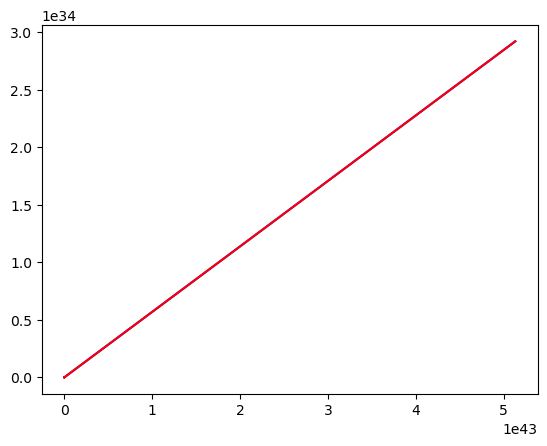

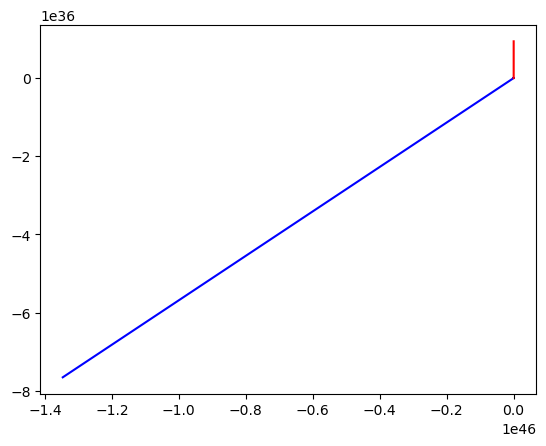

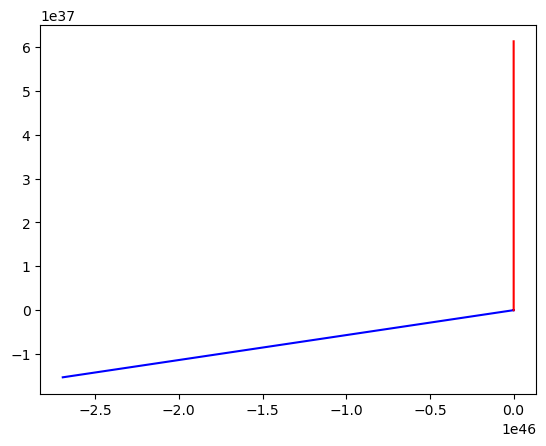

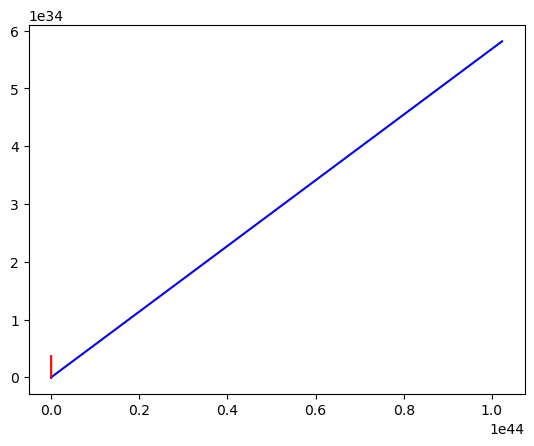

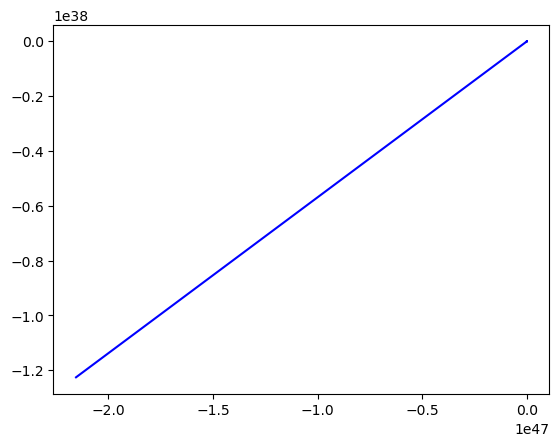

In [50]:
# Time evolution loop
positions_x = [[] for _ in range(len(particles))]
positions_y = [[] for _ in range(len(particles))]

for _ in range(int(Nt)):
    boris_push(particles, grid.E[:, :, 0], grid.E[:, :, 1], Bz, dt, grid.dx, grid.dy)

    # Record particle positions
    for i, particle in enumerate(particles):
        positions_x[i].append(particle.x)
        positions_y[i].append(particle.y)

        # Apply periodic boundary conditions
        particle.x %= grid.Lx
        particle.y %= grid.Ly

# Plot the particle trajectories
for i in range(int(len(particles)/2)):
    plt.plot(positions_x[i], positions_y[i], c="b")
    plt.plot(positions_x[-i], positions_y[-i], c="r")
    plt.show()
# plt.xlabel('x [m]')
# plt.ylabel('y [m]')
# plt.title('Particle trajectories')
# plt.legend()


In [34]:
len(particles)/2

5.0